In [1]:
import os
import numpy as np
import cv2

from matplotlib import pyplot as plt
import matplotlib 

# Local descriptors
from skimage.feature import hog
from skimage import  exposure
from skimage import feature

from time import time
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

# Definición de funciones


lbphist Definido un número de celdas, calcula el histograma LBP de cada una, concatenando los histogramas resultantes

GetHOG y GetLPB obtención de descriptores locales

GetPredictions y GetPredictionsandProbs obtienen las etiquetas o probabilidades para un conjunto de test utilizando clasificadores SVM

LoadDataset Carga conjunto de datos. Se proporciona la carpeta, a través de la variable folder, donde cada subcarpeta se corresponde con una clase. Cada clase contiene muestras en forma de imágenes jpg, todas del mismo tamaño 


In [2]:
def lbphist(gray, ncellsx, ncellsy, width, height, type):
    #Rejilla de histogramas
    pxpercellx = int(width/ncellsx)
    pxpercelly = int(height/ncellsy)

    # Rejillas de igual tamaño y centradas en la imagen de entrada
    ofx = int((width - int(pxpercellx)*ncellsx)/2)
    ofy = int((height - int(pxpercelly)*ncellsy)/2)
   
    #Obtiene histograma LBP para cada celda
    LBPu_hist = []
    for i in range(0,ncellsy):
        for j in range(0,ncellsx):
            # Extrae celda
            roi=gray[ofy+i*pxpercelly:ofy+(i+1)*pxpercelly,ofx+j*pxpercellx:ofx+(j+1)*pxpercellx]
            # Obtiene imagen LBP
            lbpimg = feature.local_binary_pattern(roi, 8, 1,method=type)
            
            #Obtiene histograma
            n_bins = int(lbpimg.max()) + 1            
            #feath, bins = np.histogram(lbpimg.ravel(), normed=True, bins=n_bins, range=(0,n_bins))
            #feath, bins = np.histogram(lbpimg, normed=False, bins=n_bins, range=(0,n_bins)) #normed deprecated
            feath, bins = np.histogram(lbpimg, density=False, bins=n_bins, range=(0,n_bins))
            
            # Concatena con celdas previas
            LBPu_hist= np.concatenate([LBPu_hist , feath])
            
    return LBPu_hist

def GetHOG(X, ncellsx, ncellsy, width, height):
    Xhog = []
    for i in range(len(X)):
        #Recompone imagen
        gray = X[i].reshape(height, width)
        
        # HOG            
        feat_hog, hog_image = hog(gray, orientations=8, pixels_per_cell=(height/ncellsy, width/ncellsx),
                    cells_per_block=(1, 1), visualize=True, block_norm='L1')   #multichannel=False,  elimindo en versiones recientes
        Xhog.append(feat_hog)
            
    return Xhog
        
def GetLBP(X, ncellsx, ncellsy, width, height, lbptype):
    Xlbp = []
    for i in range(len(X)):
        #Recompone imagen
        gray = X[i].reshape(height, width)
        
        # LBP
        feat_lbp = lbphist(gray, ncellsx, ncellsy, width, height, lbptype) 
        Xlbp.append(feat_lbp)
                
    return Xlbp

def GetPredictions(X_train, X_test, y_train, y_test):
    
    print("SVM Normalization...")
    scaler = MinMaxScaler()
    train_X = scaler.fit_transform(X_train)
    test_X = scaler.transform(X_test)

    print("SVM training...")
    t0 = time()
    parameters = {'C': [1e3, 5e3],
                  'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01],}
    # Grid searach across parameter range
    clf = GridSearchCV(
        SVC(kernel='rbf', class_weight='balanced'), parameters, cv=5
    )
    clf = clf.fit(train_X, y_train)
    print("done in %0.3fs" % (time() - t0))
    print("Best estimator found by grid search:")
    print(clf.best_estimator_)

    print("Predicting")
    t0 = time()
    # test labels
    y_pred = clf.predict(test_X)
   
    print("done in %0.3fs" % (time() - t0))
    
    return y_pred, y_test

def GetPredictionsandProbs(X_train, X_test, y_train, y_test):
    
    print("SVM Normalization...")
    scaler = MinMaxScaler()
    train_X = scaler.fit_transform(X_train)
    test_X = scaler.transform(X_test)

    print("SVM training...")
    t0 = time()
    parameters = {'C': [1e3, 5e3],
                  'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01],}
    # Grid search across parameter range
    clf = GridSearchCV(
        SVC(kernel='rbf', class_weight='balanced', probability=True), parameters, cv=5
    )
    clf = clf.fit(train_X, y_train)
    print("done in %0.3fs" % (time() - t0))
    print("Best estimator found by grid search:")
    print(clf.best_estimator_)

    print("Predicting")
    t0 = time()
    # test labels
    y_pred = clf.predict(test_X)
    
    # train and test class probabilities
    ytrain_prob = clf.predict_proba(train_X)
    ytest_prob = clf.predict_proba(test_X)
    
    print("done in %0.3fs" % (time() - t0))
    
    return y_pred, y_test, ytrain_prob, ytest_prob


def LoadDataset(folder, ext):
    # Contador de número de clases del conjunto
    nclasses = 0
    # Contador de muestras por clase
    nperclass = []
    # Etiqueta de cada clase (nombre de la subcarpeta)
    classlabels = []
    # Inicializa estructuras de datos y sus correpondientes etiquetas
    X = []
    Y = []
   
    # Asume que en la ruta indicada hay una subcarpeta por clase
    for class_name in os.listdir(folder):
        # Cada subcarpeta implica una clase más
        nclasses += 1
        # Inicialmente esta clase no tiene muestras
        nsamples = 0    

        # Compone la ruta
        class_folder = os.path.join(folder, class_name)
        for file_name in os.listdir(class_folder):
            # Imágenes en formato ext
            if file_name.endswith(ext):
                # Lee la imagen
                image = cv2.imread (os.path.join(class_folder, file_name))

                # Lugar para aplicar un RoI sobre la imagen de entrada
                # Ejemplo para la mitad superior
                # image = image[0:int(height/2),:]

                # Extrae tamaños
                height, width, depth = image.shape
                # Convierte  grises
                gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                # Añade a X, previa conversión en vector
                X.append(gray.reshape(height*width))

                # Añade etiqueta numérica de la muestra
                Y.append(nclasses-1)

                #Incrementa el número de muestras
                nsamples += 1
        
        nperclass.append(nsamples)
        classlabels.append(class_name)
    
    return X, Y, nsamples, class_name, nperclass, classlabels, width, height



# Carga y presentación de datos

Proporciona carpeta (ADAPTA A TU EQUIPO TRAS DECARGAR DATASET), carga datos mostrando primera muestra de cada clase

Loading dataset
Dataset info:
# samples: 1184
# featues: 3835
# classes: 2
classes ['Female', 'Male']
samples per class 582, 602


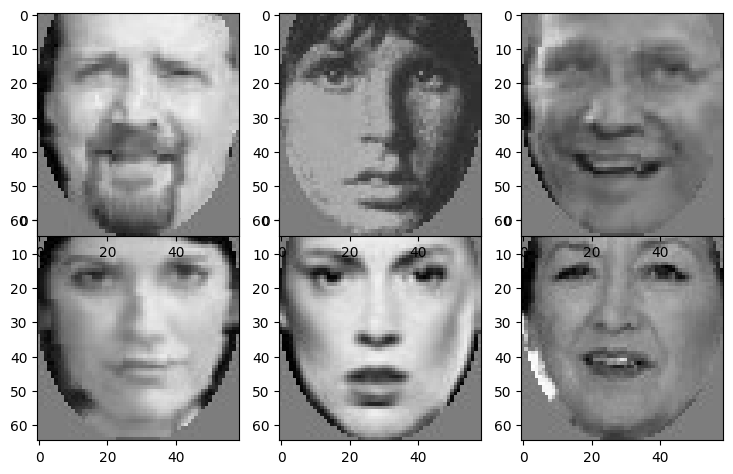

In [3]:
#MODIFICAR INDICANDO RUTA EN TU EQUIPO TRAS DESCAGAR DATOS DEL CAMPUS. EVITAR TILDES
folder = "./DatabaseGender59x65/DatabaseGender59x65" #RUTA EJEMPLO, MODIFICAR

print('Loading dataset')
X, Y, nsamples, class_name, nperclass, classlabels, width, height = LoadDataset(folder,'.jpg')

#Convierte a numpy array X e Y
X = np.array(X,dtype='float32')
Y = np.array(Y,dtype='float64')

# Obtiene número de muestras y características
n_samples , n_features = X.shape
# Obtiene nombres de las clases
class_names = np.array(classlabels)
n_classes = class_names.shape[0]

print("Dataset info:")
print("# samples: %d" % n_samples)
print("# featues: %d" % n_features)
print("# classes: %d" % n_classes)
print("classes %s" % classlabels)
print("samples per class %s" % str(nperclass)[1:-1] )
        
#Muestra primeras muestras de cada clase                                                   
# Valor de resolución por defecto de matplotlib
dpi = matplotlib.rcParams['figure.dpi']
# Imágenes de muestra de cada clase
nims2show = 3
 
for nc in range(n_classes):
    nimgs = 0
    i = 0
    while i < nims2show and nimgs < n_samples:
        #Es muestra de la clase que interesa
        if Y[nimgs] == nc:
            gray = X[nimgs].reshape(height, width)
            #Con la primera define configuración
            if i == 0 and nc == 0:                    
                figsize = 15*width / float(dpi), 15*height / float(dpi)
                fig = plt.figure(figsize=figsize)                
                        
            fig.add_subplot(nc + 1,nims2show, i + 1)
            plt.imshow(gray, cmap='gray', vmin=0, vmax=255) 

            i += 1 
        nimgs += 1
    
plt.show()






In [4]:
#Obtiene HOG y LBP para determinada configuración de celdas
#Pueden probarse otras configuraciones
Xhog4x4 = GetHOG(X, 4, 4, width, height)
Xlbp3x3 = GetLBP(X, 3, 3, width, height, "nri_uniform") #uniform a secas es también rotation invariant
    
#Convierte a numpy array X e Y
Xhog4x4 = np.array(Xhog4x4,dtype='float32')
Xlbp3x3 = np.array(Xlbp3x3,dtype='float32')

c:\Users\andsa\anaconda3\envs\detector\Lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


# Diseña conjunto experimental k-fold

Divide los datos k veces en conjunto de entrenamiento y test

In [5]:
# StratifiedKFold
# Define el número de subconjuntos a considerar
kfold = 5
skf = StratifiedKFold(n_splits=kfold, random_state=4, shuffle=True)
#Distribución de muestras por fold
fold = 1
for train_index, test_index in skf.split(X, Y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    print("Fold %d" % fold)
    print("# samples in training set %d" % train_index.shape[0])
    print("# samples in test set %d" % test_index.shape[0])
    fold += 1

Fold 1
# samples in training set 947
# samples in test set 237
Fold 2
# samples in training set 947
# samples in test set 237
Fold 3
# samples in training set 947
# samples in test set 237
Fold 4
# samples in training set 947
# samples in test set 237
Fold 5
# samples in training set 948
# samples in test set 236


# Para cada fold
Cálculo en primer término de PCA (95% de la varianza) de las muestras de entrenamiento. Posteriormente:
- Clasifica con píxeles como características y KNN
- Clasifica con componentes PCA como características con KNN
- Clasifica con componentes PCA como características con SVM
- Clasifica con LBP como características con SVM
- Clasifica con HOG como características con SVM
- Stacking de los tres últimos

In [6]:
# Compute PCA on the training subset for n_comp components
print("+++++++++++++++++++++++++++++++++++++++++++\n")
n_comp = 150

# KNN parámetros
knn = 5

#Valores de precision y recall
precs_px_knn, recs_px_knn = [], []
precs_pca_knn, recs_pca_knn = [], []
precs_pca_svm, recs_pca_svm = [], []
precs_hog_svm, recs_hog_svm = [], []
precs_lbp_svm, recs_lbp_svm = [], []
precs_stk_svm, recs_stk_svm = [], []

# Recorre folds
fold = 1
while fold <= kfold:
    accs, precs, recs = [], [], []
    for train_index, test_index in skf.split(X, Y):
        #print("TRAIN:", train_index, "TEST:", test_index)
        print("***\nFold %d" % fold)
        #División de muestras de entreno y test
        X_train, X_test = X[train_index], X[test_index]
        #Etiquetas de las muestras
        y_train, y_test = Y[train_index], Y[test_index]
        #Muestras HOG y LBP de entreno y test
        Xhog4x4_train, Xhog4x4_test = Xhog4x4[train_index], Xhog4x4[test_index]
        Xlbp3x3_train, Xlbp3x3_test = Xlbp3x3[train_index], Xlbp3x3[test_index]
        
        #####################################
        # Píxeles y KNN
        print("\nPXL+KNN")
        t0 = time()
        # k = 5 
        model_px = KNeighborsClassifier(n_neighbors = knn) 

        # fdtraining of model 
        model_px.fit(X_train, y_train) 
        print("done in %0.3fs" % (time() - t0))

        print("Predicting...")
        t0 = time()
        y_pred=model_px.predict(X_test)

        print("done in %0.3fs" % (time() - t0))
        
        print("Classification results:")
        print(classification_report(y_test, y_pred, target_names=class_names))       
        
        precs_px_knn.append(precision_score(y_test, y_pred))
        recs_px_knn.append(recall_score(y_test, y_pred))
    
        # Confusion matriz just for first fold
        if fold == 1:
            print("Confussion matrix:")
            print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))
        
        ##############################################
        print("PCA computation for .95 of the variance from %d faces..."
        % (X_train.shape[0]))
        t0 = time()
        pca_95 = PCA(.95).fit(X_train)
        print("done in %0.3fs" % (time() - t0))
        print("%d components selected" % (pca_95.n_components_ ))

        eigenfaces_95 = pca_95.components_.reshape((pca_95.n_components_ , height, width))

        print("Projecting training and test on the eigenfaces orthonormal basis")
        t0 = time()
        X_train_pca_95 = pca_95.transform(X_train)
        X_test_pca_95 = pca_95.transform(X_test)
        print("done in %0.3fs" % (time() - t0))
        
        #####################################
        # PCA y KNN
        print("\nPCA+KNN")
        print("KNN (k=%d) classifier based on %d PCA components..." % (knn, pca_95.n_components_) ) 
        t0 = time()
        model_pca_95 = KNeighborsClassifier(n_neighbors = knn) 

        # fdtraining of model 
        model_pca_95.fit(X_train_pca_95, y_train) 
        print("done in %0.3fs" % (time() - t0))

        print("Predicting...")
        t0 = time()
        y_pred=model_pca_95.predict(X_test_pca_95)

        print("done in %0.3fs" % (time() - t0))

        print("\nMetrics")
        print(classification_report(y_test, y_pred, target_names=class_names))
        precs_pca_knn.append(precision_score(y_test, y_pred))
        recs_pca_knn.append(recall_score(y_test, y_pred))
        
        if fold == 1:
            print("Confusion matrix:")
            print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))
        
        print("+++++++++++++++++++++++++++++++++++++++++++\n")
        #####################################
        # PCA y SVM
        print("\nPCA+SVM")        
        y_pred, y_test = GetPredictions(X_train_pca_95, X_test_pca_95,y_train, y_test)
        print("\nMetrics")
        print(classification_report(y_test, y_pred, target_names=class_names))
        precs_pca_svm.append(precision_score(y_test, y_pred))
        recs_pca_svm.append(recall_score(y_test, y_pred))

        if fold == 1:
            print("Confusion matrix:")
            print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))
            
        #####################################
        # HOG y SVM
        print("\nHOG+SVM")
        y_pred, y_test = GetPredictions(Xhog4x4_train, Xhog4x4_test,y_train, y_test)
        print("\nHOG Metrics")
        precs_hog_svm.append(precision_score(y_test, y_pred, average='weighted'))
        recs_hog_svm.append(recall_score(y_test, y_pred, average='weighted'))
        print(classification_report(y_test, y_pred, target_names=class_names))
        if fold == 1:
            print("Confusion matrix:")
            print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))        
        
        #####################################
        # LBP y SVM
        print("\nLBP+SVM")
        y_pred, y_test = GetPredictions(Xlbp3x3_train, Xlbp3x3_test,y_train, y_test)
        print("\nLBP Metrics")
        precs_lbp_svm.append(precision_score(y_test, y_pred, average='weighted'))
        recs_lbp_svm.append(recall_score(y_test, y_pred, average='weighted'))
        print(classification_report(y_test, y_pred, target_names=class_names))
        if fold == 1:
            print("Confusion matrix:")
            print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))


        #####################################
        #Ensemble
        print("\nEnsemble/Stacking")
        #Obtiene también probs
        y_pred, y_test, pca95_train_prob, pca95_test_prob = GetPredictionsandProbs(X_train_pca_95, X_test_pca_95,y_train, y_test)
        y_pred, y_test, hog_train_prob, hog_test_prob = GetPredictionsandProbs(Xhog4x4_train, Xhog4x4_test,y_train, y_test)
        y_pred, y_test, lbp_train_prob, lbp_test_prob = GetPredictionsandProbs(Xlbp3x3_train, Xlbp3x3_test,y_train, y_test)
        #Score level fusion, using reported probabilities. Tranposr matrix is later used
        X_train = np.vstack((pca95_train_prob[:,1],hog_train_prob[:,1],lbp_train_prob[:,1]))
        X_test = np.vstack((pca95_test_prob[:,1],hog_test_prob[:,1],lbp_test_prob[:,1]))
        y_pred, y_test = GetPredictions(X_train.T,X_test.T,y_train, y_test)
            
        print("\nEnsemble/Stacking Metrics")
        precs_stk_svm.append(precision_score(y_test, y_pred, average='weighted'))
        recs_stk_svm.append(recall_score(y_test, y_pred, average='weighted'))
        print(classification_report(y_test, y_pred, target_names=class_names))
        print("Confusion matrix:")
        print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))
        
        fold += 1

print("\n********K-FOLD SUMMARY*********")
print("PX+KNN Mean Precision:  %0.3f, Mean Recall:  %0.3f" % ( np.mean(precs_px_knn) , np.mean(recs_px_knn) )) 
print("PCA+KNN Mean Precision:  %0.3f, Mean Recall:  %0.3f" % ( np.mean(precs_pca_knn) , np.mean(recs_pca_knn) )) 
print("PCA+SVM Mean Precision:  %0.3f, Mean Recall:  %0.3f" % ( np.mean(precs_pca_svm) , np.mean(recs_pca_svm) )) 
print("HOG+SVM Mean Precision:  %0.3f, Mean Recall:  %0.3f" % ( np.mean(precs_hog_svm) , np.mean(recs_hog_svm) )) 
print("LBP+SVM Mean Precision:  %0.3f, Mean Recall:  %0.3f" % ( np.mean(precs_lbp_svm) , np.mean(recs_lbp_svm) )) 
print("Ensemble Mean Precision:  %0.3f, Mean Recall:  %0.3f" % ( np.mean(precs_stk_svm) , np.mean(recs_stk_svm) )) 

    

+++++++++++++++++++++++++++++++++++++++++++

***
Fold 1

PXL+KNN
done in 0.004s
Predicting...


c:\Users\andsa\anaconda3\envs\detector\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


done in 1.978s
Classification results:
              precision    recall  f1-score   support

      Female       0.77      0.69      0.73       117
        Male       0.73      0.80      0.76       120

    accuracy                           0.75       237
   macro avg       0.75      0.75      0.75       237
weighted avg       0.75      0.75      0.75       237

Confussion matrix:
[[81 36]
 [24 96]]
PCA computation for .95 of the variance from 947 faces...
done in 1.110s
159 components selected
Projecting training and test on the eigenfaces orthonormal basis
done in 0.012s

PCA+KNN
KNN (k=5) classifier based on 159 PCA components...
done in 0.001s
Predicting...
done in 0.012s

Metrics
              precision    recall  f1-score   support

      Female       0.77      0.66      0.71       117
        Male       0.71      0.81      0.75       120

    accuracy                           0.73       237
   macro avg       0.74      0.73      0.73       237
weighted avg       0.74      0.73